### Import packages

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
!pip install keras-tuner
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

### Load and prepare data

In [6]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)
n_residual_blocks = 5

# The data, split between train and test sets
mnist = keras.datasets.mnist
(x, _), (y, _) = mnist.load_data()

# Concatenate all the images together
data = np.concatenate((x, y), axis=0)

# Round all pixel values less than 33% of the max 256 value to 0
data = np.where(data < (0.33 * 256), 0, 1)
data = data.astype(np.float32)

### Model Architecture

In [3]:
class PixelConvLayer(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super().__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)


class ResidualBlock(keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )
        self.pixel_conv = PixelConvLayer(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return keras.layers.add([inputs, x])

In [4]:
inputs = keras.Input(shape=input_shape)
x = PixelConvLayer(
    mask_type="A", filters=128, kernel_size=7, activation="relu", padding="same"
)(inputs)

for _ in range(n_residual_blocks):
    x = ResidualBlock(filters=128)(x)

for _ in range(2):
    x = PixelConvLayer(
        mask_type="B",
        filters=128,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = keras.layers.Conv2D(
    filters=1, kernel_size=1, strides=1, activation="sigmoid", padding="valid"
)(x)

pixel_cnn = keras.Model(inputs, out)
adam = keras.optimizers.Adam(learning_rate=0.0005)
pixel_cnn.compile(optimizer=adam, loss="binary_crossentropy")

pixel_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 pixel_conv_layer (PixelConv  (None, 28, 28, 128)      6400      
 Layer)                                                          
                                                                 
 residual_block (ResidualBlo  (None, 28, 28, 128)      98624     
 ck)                                                             
                                                                 
 residual_block_1 (ResidualB  (None, 28, 28, 128)      98624     
 lock)                                                           
                                                                 
 residual_block_2 (ResidualB  (None, 28, 28, 128)      98624     
 lock)                                                       

### Fitting

In [5]:
pixel_cnn.fit(
    x=data, y=data, batch_size=64, epochs=10, validation_split=0.1, verbose=1
)

Epoch 1/10
985/985 [==============================] - 1156s 1s/step - loss: 0.1027 - val_loss: 0.0897
Epoch 2/10
985/985 [==============================] - 1159s 1s/step - loss: 0.0889 - val_loss: 0.0895
Epoch 3/10
985/985 [==============================] - 1153s 1s/step - loss: 0.0873 - val_loss: 0.0872
Epoch 4/10
985/985 [==============================] - 1151s 1s/step - loss: 0.0864 - val_loss: 0.0861
Epoch 5/10
985/985 [==============================] - 1173s 1s/step - loss: 0.0858 - val_loss: 0.0857
Epoch 6/10
985/985 [==============================] - 1158s 1s/step - loss: 0.0853 - val_loss: 0.0859
Epoch 7/10
985/985 [==============================] - 1157s 1s/step - loss: 0.0849 - val_loss: 0.0847
Epoch 8/10
985/985 [==============================] - 1158s 1s/step - loss: 0.0845 - val_loss: 0.0849
Epoch 9/10
985/985 [==============================] - 1151s 1s/step - loss: 0.0843 - val_loss: 0.0848
Epoch 10/10
985/985 [==============================] - 1448s 1s/step - loss: 0.084

### Performance matrix

In [9]:
# Generate a batch of images
generated_images = pixel_cnn.predict(data[:100])

# Flatten the images for simplicity in calculation
real_images_flat = data[:100].reshape(data[:100].shape[0], -1)
generated_images_flat = generated_images.reshape(generated_images.shape[0], -1)

# Calculate Mean Squared Error (MSE) and then take the square root for RMSE
mse = mean_squared_error(real_images_flat, generated_images_flat)
rmse = np.sqrt(mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(real_images_flat, generated_images_flat)

# Assuming binary cross-entropy loss, calculate it manually
epsilon = 1e-7  # to prevent log(0)
bce_loss = -np.mean(
    real_images_flat * np.log(generated_images_flat + epsilon) + 
    (1 - real_images_flat) * np.log(1 - generated_images_flat + epsilon)
)

# Compile metrics into a DataFrame
metrics_dict = {
    'Metric': ['BCE Loss', 'RMSE', 'MAE'],
    'Value': [bce_loss, rmse, mae]
}

metrics_df = pd.DataFrame(metrics_dict)
print(metrics_df)

4/4 [==============================] - 2s 264ms/step
     Metric     Value
0  BCE Loss  0.083294
1      RMSE  0.156060
2       MAE  0.048182


### Display images

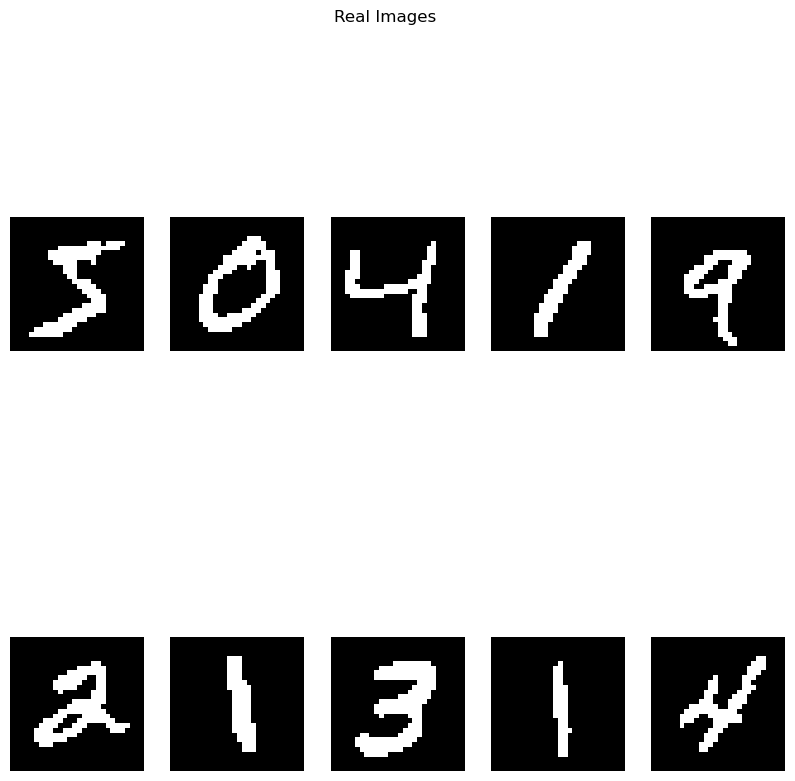

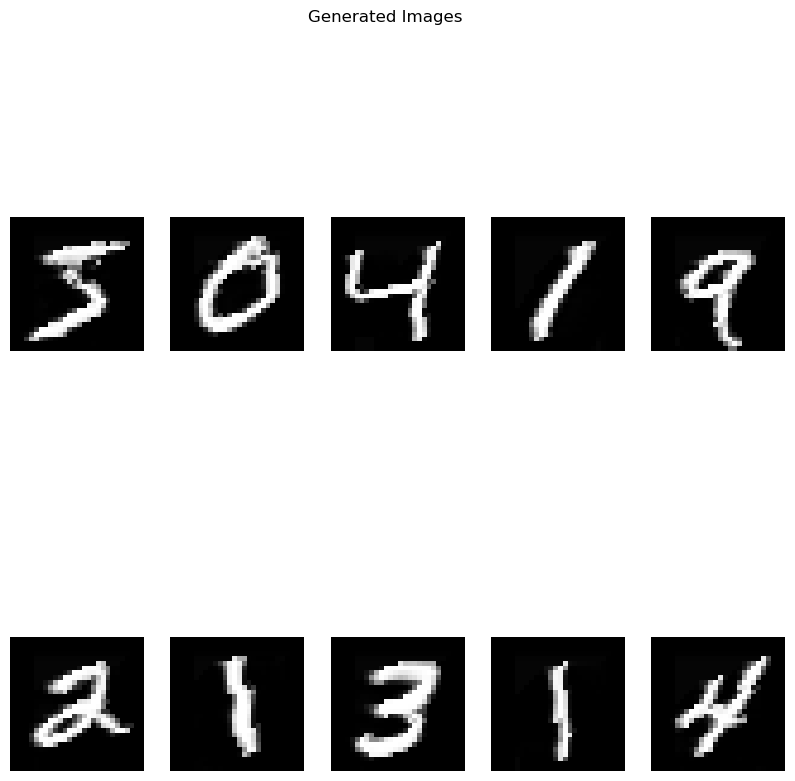

In [13]:
def display_images(images, title):
    plt.figure(figsize=(10, 10))
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

# Display real images
display_images(data[:10], "Real Images")

# Display generated images
display_images(generated_images[:10], "Generated Images")

In [ ]:
generated_images = pixel_cnn.predict(data).reshape((10000, 1, 28, 28))